# Packages

## Install POT

In [1]:
!pip install POT
!pip install --upgrade numpy

Requirement already up-to-date: numpy in /opt/anaconda3/lib/python3.8/site-packages (1.22.2)


## Install gudhi + optmizer packages

In [ ]:
!pip install gudhi

     |████████████████████████████████| 29.3 MB 1.4 MB/s 


In [ ]:

!pip install tensorflow_addons
!pip install git+https://github.com/master/tensorflow-riemopt.git

     |████████████████████████████████| 1.1 MB 5.3 MB/s 
  Cloning https://github.com/master/tensorflow-riemopt.git to /tmp/pip-req-build-tdrgndo0
  Running command git clone -q https://github.com/master/tensorflow-riemopt.git /tmp/pip-req-build-tdrgndo0
     |████████████████████████████████| 458.3 MB 12 kB/s 
     |████████████████████████████████| 5.6 MB 40.7 MB/s 
     |████████████████████████████████| 14.8 MB 37.3 MB/s 
     |████████████████████████████████| 1.3 MB 27.5 MB/s 
     |████████████████████████████████| 462 kB 55.0 MB/s 
     |████████████████████████████████| 132 kB 28.2 MB/s 
  Created wheel for tensorflow-riemopt: filename=tensorflow_riemopt-0.1.0-py3-none-any.whl size=45244 sha256=7b10fed5ccd1420fddcbb2b26f591e718f1bcf926cc907982feb887ac8d542a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-jt91spdx/wheels/f5/3c/6c/a6eebf4b391b6af4cb01f873345d494c35c02b3883636d1a94
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=d28225e5b3fccf7

In [ ]:
!pip install eagerpy

## Import

In [3]:
import numpy               as np
import tensorflow_addons   as tfa
import tensorflow          as tf
import matplotlib.pyplot   as plt
import pandas              as pd
import gudhi               as gd


from gudhi.wasserstein     import wasserstein_distance
from mpl_toolkits.mplot3d  import Axes3D
from sklearn.metrics       import pairwise_distances


import tensorflow_riemopt as manopt
import ot #pot

#import tensorflow_manopt as manopt <---- didn't work. ??

#from scipy.stats import wasserstein_distance

In [4]:
# import packages
import scipy
from scipy.stats import norm 
import time
import statsmodels.api as sm
import math

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import normalize
from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.models import Model

# `data_generation.py`

In [9]:
    ## INVERSE TRANSFORM 

# generate sample from normal distribution using inverse transform sampling 
def InverseTransform(mu, sigma, n_samples):

  # start counter
  tic = time.perf_counter() 

  # simulate uniformly randomly distributed data of size n_samples
  u = np.random.uniform(0, 1, n_samples)

  # perform inverse transform sampling, scale by sigma, and translate by mu
  x = norm.ppf(u) * sigma + mu # quantile of standard normal distribution, scaled

  # end counter
  toc = time.perf_counter()

  # plot histogram of generated data
  plt.hist(x)
  plt.show()

  # plot qqplot of generated data
  sm.qqplot(x) #defaut comparison distribution is standard normal
  plt.show()

  # extract mean and standard deviation from generated data
  mu_new, sigma_new = norm.fit(x)

  # print given and generated parameters
  print("univariate inverse transform took {} seconds".format(toc - tic))
  print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
  print("generated: mu = {}, sigma = {}".format(mu_new, sigma_new)) # print generated parameters

    return x

## BOX-MULLER

# generate sample from normal distribution using Box-Muller Transform
def BoxMuller(mu,sigma,n,plot=False):
  
  # start counter
  tic = time.perf_counter() 

  # simulate theta and r
  u1, u2 = np.random.uniform(0,1,n), np.random.uniform(0,1,n)
  r = np.sqrt(-2*np.log(1-u1))
  theta = 2*np.pi*u2

  # calculcate x coordinate
  x = np.cos(theta)*r*sigma + mu

  # end counter
  toc = time.perf_counter() 

  if plot == True:

    # plot histogram of generated data
    plt.hist(x,density=True)
    plt.show()

    # plot qqplot of generated data
    sm.qqplot(x)
    plt.show()

    # mean and standard deviation from generated data
    mu_new, sigma_new = norm.fit(x)
    
    print("univariate Box Muller transform took {} seconds".format(toc - tic))
    print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
    print("generated: mu = {}, sigma = {}".format(mu_new, sigma_new)) # print generated parameters

    return x

def BoxMullerAlt(n,mu=0,sigma=1):

  # start counter
  tic = time.perf_counter() 

  # simulate random uniformly distributed data of size n
  u1, u2 = np.random.uniform(0,1,n), np.random.uniform(0,1,n)

  # apply inverse cdf of exponential to u1
  s = -np.log(1-u1)  

  # transform u2 to theta
  theta = 2*np.pi*u2

  # convert s to r
  r = np.sqrt(2*s)

  # generate z1,z2 from r and theta
  z1, z2 = (r*np.cos(theta)*sigma + mu), (r*np.sin(theta)*sigma + mu)

  # end counter
  toc = time.perf_counter() 

  # plot histogram and scatterplot
  fig = plt.figure(figsize=plt.figaspect(0.4))
  ax = fig.add_subplot(1,2,1)
  ax.hist(z1)
  ax.hist(z2)
  ax = fig.add_subplot(1,2,2)
  ax.scatter(z1,z2,s=0.5)

  # plot qqplot of generated data
  sm.qqplot(z1)
  plt.show()
  sm.qqplot(z2)
  plt.show()

  # extract mean and standard deviation from generated data
  mu_1, sigma_1 = norm.fit(z1)
  mu_2,sigma_2 = norm.fit(z2)

  # print given and generated parameters
  print("univariate alternative Box Muller transform took {} seconds".format(toc - tic))
  print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
  print("generated z1: mu = {}, sigma = {}".format(mu_1, sigma_1)) # print generated parameters for z1
  print("generated z2: mu = {}, sigma = {}".format(mu_2, sigma_2)) # for z2


## CENTRAL LIMIT THEOREM

def CentralLimitTheorem(mu,sigma,n_means,n_samples):
  
  # start counter
  tic = time.perf_counter() 

  # generate data
  matrix = np.random.uniform(0,1,size=(n_means,n_samples))
  
  # calculcate sample means
  sampleMeans = matrix.sum(axis=0)/n_samples

  # standardize
  mean = np.mean(sampleMeans)
  sd = np.std(sampleMeans)
  standard = (sampleMeans - mean)/sd

  # scale by sigma, translate by mu
  normal = standard*sigma+mu
  
  # end counter
  toc = time.perf_counter() 

  # plot histogram of generated data
  plt.hist(normal)
  plt.show()

  # plot qqplot of generated data
  sm.qqplot(normal)
  plt.show()

  # mean and standard deviation from generated data
  mu_new = np.mean(normal)
  sigma_new = np.std(normal)

  # print given and generated parameters
  print("univariate CLT took {} seconds".format(toc - tic))
  print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
  print("generated: mu = {}, sigma = {}".format(mu_new, sigma_new)) # print generated parameters


## MULTIVARIATE INVERSE TRANSFORM

np.random.seed(000)

# helper function to determine if inputted cov_matrix is valid covariance matrix
def is_cov_mat(x,tol=1e-8):

  # check if matrix is symmetric
    if np.array_equal(x,x.T): 

    # check if diagonal entries are non-negative  
        if any(n < 0 for n in x.diagonal()):
        return False
    
    # check if matrix is positive semi-definite
        else:      
            E = np.linalg.eigvalsh(x)
            return np.all(E > -tol)   
    else:
        return False

# generate sample from multivariate normal distribution using Inverse Transform Sampling
def multiNormalSample_ITS(mu, cov_matrix, n_samples, n_dim):
  if is_cov_mat(cov_matrix):
    # start counter
    tic = time.perf_counter() 
  
    # initialize sample matrix as zeros
    z = np.zeros((n_dim,n_samples)) 

    # populate matrix independently with values from the univariate standard normal
    for d in list(range(0,n_dim)):
      u = np.random.uniform(0, 1, n_samples)
      z[d] = norm.ppf(u)
    
    # compute square root of covariance matrix through eigenvalue decomposition
    eigval, eigvec = np.linalg.eig(cov)
    print(eigval)
    print(eigvec)
    eigval_sqrt = np.diag(np.sqrt(eigval))
    print(eigval_sqrt)
    cov_sqrt = np.matmul(np.matmul(eigvec, eigval_sqrt),eigvec.T)

    # compute 
    x = np.matmul(cov_sqrt,z) + mu 
  
    # end counter
    toc = time.perf_counter()
  
    # print time taken
    print("multivariate sampling took {} seconds".format(toc - tic)) 
    
    # print eigenvalues
    print("the eigenvalues of the covariance matrix were {}".format(eigval)) 

    return x

  else:
    return("Inputted covariance matrix is invalid")


## MULTIVARIATE BOX-MULLER

# generate sample from multivariate normal distribution using Box Muller Transform
def multiNormalSample_BM(mu, cov_matrix, n_samples, n_dim):
    if is_cov_mat(cov_matrix):
    # start counter
    tic = time.perf_counter() 
  
    # initialize sample matrix as zeros
    z = np.zeros((n_dim,n_samples)) 

    # populate matrix independently with values from the univariate standard normal
    for d in list(range(0,n_dim)):
      # simulate theta and r
      theta = np.random.uniform(0,2*np.pi,n_samples)
      r = np.sqrt(2*np.random.exponential(1,n_samples))

     # calculcate x coordinate
      z[d] = np.cos(theta)*r
    
    # compute square root of covariance matrix through eigenvalue decomposition
    eigval, eigvec = np.linalg.eig(cov_matrix)
    eigval_sqrt = np.diag(eigval*1/2)
    cov_sqrt = np.matmul(np.matmul(eigvec, eigval_sqrt),eigvec.T)

    # print eigenvalues
    # print("eigenvalues of covariance matrix:", eigval)

    # compute 
    x = np.matmul(cov_sqrt,z) + mu 
  
    # end counter
    toc = time.perf_counter()
  
    # print time take
    # print("multivariate sampling took {} seconds".format(toc - tic)) 
    
    return x
  
    else:
        return("Inputted covariance matrix is invalid")


## MAKE BLOBS

def make_n_blobs(n_samples=100,n_features=2,centers=4,mu_coef=20,sigma_coef=4,user_mu=[],weights=[0.1,0.2,0.3,0.4]):
  # divide total number of samples by number of blobs (no remainder)
  n_samples //= centers # each blob will have this many data points

  # check if user has provided array of mean vectors
  manual_mu = False
    if np.shape(user_mu) == (centers,n_features): # (num blobs x num dimensions)
    # will use user inputted mu
    manual_mu = True
    else:
    # initialize mu
    mu = np.random.randn(n_features,1)

  tic = time.perf_counter() # start timer

  # initialize data matrix
  data = np.zeros((n_features,n_samples * centers))
  data_labels = np.zeros((n_samples * centers, 1))

  # plt.figure()
  # loop through blobs
  for i in range(centers):
    # generate a random invertible matrix
    A = np.random.randn(n_features,n_features) # generate a random matrix

    # compute eigenvalue decomoposition of symmetric matrix
    A_symmetric = A @ A.transpose()
    D, U = np.linalg.eig(A_symmetric)

    # generate eigenvalues close to each other    
    eig_starter = max(2,np.random.randn()) # CONTROLS COVARIANCE
    eigs = np.zeros(n_features) + eig_starter
    for j in range(1,n_features):
      adder = np.random.rand() / sigma_coef
      eigs[j] = eig_starter * (1 + adder)
    eigs = np.array(list(eigs))
    
    # generate matrix with desired eigenvalues
    new_A = U @ np.diag(eigs) @ np.linalg.inv(U)

    # generate positive semidefinite covariance matrix
    cov_matrix = new_A @ new_A.transpose()

    # generate mean vector
    if manual_mu == True:
      mu = np.array(user_mu[i]).reshape((n_features,1)) # use user inputted mu
    else:
      mu += mu_coef * np.random.rand(n_features,1) # CONTROLS MEAN

    # generate data
    X = multiNormalSample_BM(mu, cov_matrix, n_samples, n_features) # use Box Muller    
    data[:,n_samples*i:n_samples*(i+1)] = X
    data_labels[n_samples*i:n_samples*(i+1)] = i

  toc = time.perf_counter() # end timer

  print("from scratch make blobs took {} seconds".format(toc - tic))

  # output full data matrix
  return(data, data_labels)


  ## MAKE BLOBS - MIXTURE MODEL

def mixture_make_blobs(n_samples=100,n_features=2,centers=4,
                       mu_coef=20,sigma_coef=4,mu_vec=[],
                       bins=[0.3,0.5,0.8,1]):
  # if user has not provided valid array of mean vectors, initialize
  manual_mu = True
  if np.shape(mu_vec) != (centers,n_features): # (num blobs x num dimensions)
    manual_mu = False
    mu_vec = []
    mu = np.random.randn(n_features,1)

  tic = time.perf_counter() # start timer

  # initialize covariance vector
  cov_vec = []

  # initialize data matrix
  data = np.zeros((n_features,n_samples))
  data_labels = np.zeros((n_samples, 1))

  # loop through blobs to create means and covariance
  for i in range(centers):
    # generate a random invertible matrix
    A = np.random.randn(n_features,n_features) # generate a random matrix

    # compute eigenvalue decomoposition of symmetric matrix
    A_symmetric = A @ A.transpose()
    D, U = np.linalg.eig(A_symmetric)

    # generate eigenvalues close to each other    
    eig_starter = np.random.uniform(1,2) # CONTROLS COVARIANCE
    eigs = np.zeros(n_features) + eig_starter
    for j in range(1,n_features):
      adder = np.random.rand() / sigma_coef
      eigs[j] = eig_starter * (1 + adder)
    eigs = np.array(list(eigs))
    
    # generate matrix with desired eigenvalues
    new_A = U @ np.diag(eigs) @ np.linalg.inv(U)

    # generate positive semidefinite covariance matrix
    cov_matrix = new_A @ new_A.transpose()
    cov_vec.append(cov_matrix)

    # generate mean vector
    if manual_mu == False:
      mu += mu_coef * np.random.rand(n_features,1) # CONTROLS MEAN
      mu_vec.append(mu.tolist())

  # loop through samples and draw from mixture distribution
  for j in range(n_samples):
    # generate random number in [0,1]
    alpha = np.random.uniform()

    # identify the index of weighted bin in which alpha belongs
    k = np.digitize(alpha,bins)

    # use mean and covariance from the chosen index
    mu = mu_vec[k]
    cov_matrix = cov_vec[k]

    # generate data
    X = multiNormalSample_BM(mu, cov_matrix, 1, n_features).flatten() # use Box Muller   
    data[:,j] = X
    data_labels[j] = k

  toc = time.perf_counter() # end timer

  print("mixture make blobs took {} seconds".format(toc - tic))
  # output full data matrix
  return(data, data_labels)


## GENERATE UNIFORM DATA ON SPHERE
def unif_sphere(n_samples=1000,n_features=3,radius=1,plot=False):
  # generate random normal data
  X = np.zeros((n_features,n_samples))

  for i in range(n_features):
    x=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False).tolist()
    X[i,:] = x

  for i in range(n_samples):
    X[:,i] = X[:,i]/np.linalg.norm(X[:,i]) * radius
 
  if plot != False:
    for j in range(n_features):
      sm.qqplot(X[j,:], dist=scipy.stats.uniform)

  # plot
  if plot != False:
    if n_features == 2:
      plt.scatter(X[0,:],X[1,:])
    elif n_features == 3:
      fig = plt.figure(figsize=plt.figaspect(1))
      ax = fig.add_subplot(projection='3d')
      ax.set_xlabel('x')
      ax.set_ylabel('y')
      ax.set_zlabel('z')
      ax.scatter(X[0,:],X[1,:],X[2,:])
      ax.view_init(0,45)
    else:
      print("no visualization available")

  return(X)

def uniform_sphere_polar(n_samples = 1000, r = 1,plot=False):

  phi = np.random.uniform(0,np.pi,n_samples)
  theta = np.random.uniform(0,2*np.pi,n_samples) 

  x=r*np.cos(phi)*np.sin(theta)
  y=r*np.sin(phi)*np.sin(theta)
  z=r*np.cos(theta)

  if plot != False:

    sm.qqplot(x, dist=scipy.stats.uniform)
    sm.qqplot(y, dist=scipy.stats.uniform)
    sm.qqplot(z, dist=scipy.stats.uniform)

    fig = plt.figure(figsize=plt.figaspect(1))
    ax=fig.add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x,y,z)
    ax.view_init(0,45)
  
  return(x,y,z)

def uniform_circle(n_samples = 1000, r =1,plot=False):
  theta = np.random.uniform(0,2*np.pi,n_samples)
  x = r*np.sin(theta)
  y=r*np.cos(theta)

  # sm.qqplot(x, dist=scipy.stats.uniform)

  # sm.qqplot(y, dist=scipy.stats.uniform)

  if plot != False:
    plt.figure()
    plt.scatter(x,y)
    plt.scatter(theta)
  
  return(x,y)

def uniform_sphere_from_normal(n_samples = 1000, r = 1,plot=False):

  x=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False)
  y=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False)
  z=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False)

  for i in range(n_samples):
    v=[x[i],y[i],z[i]]
    x[i]=x[i]/np.linalg.norm(v)
    y[i]=y[i]/np.linalg.norm(v)
    z[i]=z[i]/np.linalg.norm(v)

  x,y,z = x*r, y*r, z*r

  if plot != False:
    fig = plt.figure(figsize=plt.figaspect(1))
    ax=fig.add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x,y,z)
    ax.view_init(0,45)

  return(x,y,z)


## GENERATE UNIFORM DATA ON CYLINDER

def unif_cylinder(n_samples=1000,radius=1,height=100,n_features=3):
  # initialize data matrix
  X = np.zeros((n_features,n_samples))

  circ_dim = n_features - 1
  # generate a 2-d uniformly random circles
  X[:circ_dim,:] = unif_sphere(n_samples=n_samples,n_features=circ_dim,radius=1)
  
  # add uniformly random values of the third dimension to circles
  X[circ_dim,:] = np.random.uniform(0,height,n_samples).tolist()

#   fig = plt.figure(figsize=plt.figaspect(0.5))
#   ax = fig.add_subplot(1,2,2,projection='3d')
#   ax.set_xlabel('x')
#   ax.set_ylabel('y')
#   ax.set_zlabel('z')
#   ax.scatter(X[0,:],X[1,:],X[2,:])
#   ax.view_init(90,0)

#   ax = fig.add_subplot(1,2,1,projection='3d')
#   ax.set_xlabel('x')
#   ax.set_ylabel('y')
#   ax.set_zlabel('z')
#   ax.scatter(X[0,:],X[1,:],X[2,:])
#   ax.view_init(45,45)
  return(X)

## GENERATE UNIFORM DATA ON SQUARE

def uniform_square(side_length=1,n_samples=1000,center=[0,0],dim=2,angle_degree = 45):
    
    angle = angle_degree* np.pi/180 #degrees to radians 
    dist_from_center = side_length/2
    samples_per_side = math.floor(n_samples/4)
    
    top_x  = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    top_y = np.repeat(dist_from_center,samples_per_side)
    top = np.asarray((top_x,top_y)).transpose()
    
    bottom_x  = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    bottom_y = np.repeat(-dist_from_center,samples_per_side)
    bottom = np.asarray((bottom_x,bottom_y)).transpose()
    
    left_y  = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    left_x = np.repeat(-dist_from_center,samples_per_side)
    left = np.asarray((left_x,left_y)).transpose()
    
    right_y = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    right_x = np.repeat(dist_from_center,samples_per_side)
    right = np.asarray((right_x,right_y)).transpose()
    
    X = np.concatenate((top,bottom,left,right))

    #rotate the square
    for i in range(n_samples):
        point = X[i]
        x = point[0]
        y = point[1]
        #rotation matrix
        X[i][0] = (x*np.cos(angle)) - (y*np.sin(angle))
        X[i][1] = (x*np.sin(angle)) + (y*np.cos(angle))

    #shift shape from the center
    X += center  

    #plot 
    plt.scatter(X[:,0],X[:,1])
    plt.axis("equal")


def square(side_length=1,n_samples=1000,dim1=True, dim2= True, dim3 = True, adder = 0,plot=False):

  X = np.zeros((3,n_samples)) + adder

  if dim1 == True:
    X[0,:] = np.random.uniform(0,side_length,n_samples) 
  if dim2 == True:  
    X[1,:] = np.random.uniform(0,side_length,n_samples)
  if dim3 == True:
    X[2,:] = np.random.uniform(0,side_length,n_samples)


  if plot != False:
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(X[0,:],X[1,:],X[2,:])
    ax.view_init(45,45)

  return(X)


## GENERATE UNIFORM DATA ON CUBE
## FILLED CUBE

def cube(side_length=1,n_samples=10000):

  X = np.zeros((3,n_samples))

  X[0,:] = np.random.uniform(0,side_length,n_samples) 
  X[1,:] = np.random.uniform(0,side_length,n_samples) 
  X[2,:] = np.random.uniform(0,side_length,n_samples) 

  fig = plt.figure(figsize=plt.figaspect(1))
  ax = fig.add_subplot(projection='3d')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.scatter(X[0,:],X[1,:],X[2,:])
  ax.view_init(45,45)

## EMPTY CUBE

def empty_cube(side_length=1,n_samples=10000,center=[0,0,0],dim=2,angle_degree = 45,plot=True):
    
    center = np.array(center).reshape(3,1)
    angle = angle_degree* np.pi/180 #degrees to radians 
    dist_from_center = side_length/2
    samples_per_side = math.floor(n_samples/6)

 
    side1 = square(n_samples=samples_per_side, dim1=False) - dist_from_center
    side2 = square(n_samples=samples_per_side, dim1=False, adder = side_length) - dist_from_center

    side3 = square(n_samples=samples_per_side, dim2=False) - dist_from_center
    side4 = square(n_samples=samples_per_side, dim2=False, adder = side_length) - dist_from_center

    side5 = square(n_samples=samples_per_side, dim3=False) - dist_from_center
    side6 = square(n_samples=samples_per_side, dim3=False, adder = side_length) - dist_from_center

    #verify cube
    X_hollow = np.concatenate((side1,side2,side3,side4),axis=1) + center

    X = np.concatenate((side1,side2,side3,side4,side5,side6),axis=1) + center

    if plot != False:
      fig = plt.figure(figsize=plt.figaspect(0.5))
      ax = fig.add_subplot(1,2,1,projection='3d')
      ax.scatter(X[0,:],X[1,:],X[2,:])
      ax.view_init(45,45)

      ax = fig.add_subplot(1,2,2,projection='3d')
      ax.scatter(X_hollow[0,:],X_hollow[1,:],X_hollow[2,:])
      ax.view_init(90,0)
    
    return(X)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 183)

# Rips Model

In [10]:
def Rips(DX, mel, dim, card):
    # Parameters: DX (distance matrix), 
    #             mel (maximum edge length for Rips filtration), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    rc = gd.RipsComplex(distance_matrix=DX, max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=dim+1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    for s1, s2 in pairs:
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    return list(np.array(indices, dtype=np.int32))

class RipsModel(tf.keras.Model):
    def __init__(self, P, mel=12, dim=1, card=150):
        super(RipsModel, self).__init__()
        self.P = P
        self.mel = mel
        self.dim = dim
        self.card = card
        
    # Question: What is the purpose of this function?
    def call(self):
        m, d, c = self.mel, self.dim, self.card

        #Question: Why are distances being calculcated here? why does gradient keyword show up?

        # Compute distance matrix
        DX = tfa.losses.metric_learning.pairwise_distance(X)
        DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        
        # Turn numpy function into tensorflow function
        XRipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Xids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(XRipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Xdgm = tf.reshape(tf.gather_nd(DX, tf.reshape(Xids, [2*c,2])), [c,2])


        #Z=X@self.P
        Z=self.P
        # Compute distance matrix
        DZ = tfa.losses.metric_learning.pairwise_distance(Z)
        DZZ = tf.reshape(DZ, [1, DZ.shape[0], DZ.shape[1]])
        
        # Turn numpy function into tensorflow function
        ZRipsTF = lambda DZ: tf.numpy_function(Rips, [DZ, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Zids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(ZRipsTF,DZZ,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Zdgm = tf.reshape(tf.gather_nd(DZ, tf.reshape(Zids, [2*c,2])), [c,2])
        return (Xdgm,Zdgm)

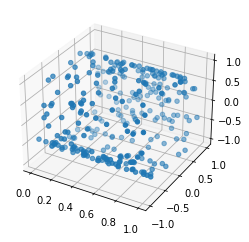

In [11]:
np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back
ss3=np.random.uniform(0,2*np.pi,300)
noise=np.random.normal(0,0.1,300) #add noise if you want


noise = 0 #to cancel noise
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)



rr3=np.random.uniform(0,1,300) #a point (xx,yy,rr3) on 3D
ax = plt.subplot(111, projection='3d')
ax.scatter(rr3,xx,yy) 
X=np.array(np.mat([rr3,xx,yy]).T,dtype=np.float32)
Z=X[:,:2]
plt.show()

In [13]:
modelR = RipsModel(P=Z, mel=12, dim=1, card = 150)

Zdgm = modelR.call()[1]
print(type(Zdgm))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [12]:
from data_generation import *

In [ ]:
type(tf.convert_to_tensor(Zdgm))

tensorflow.python.framework.ops.Tensor

In [39]:
tf.__version__

'2.6.2'

In [ ]:
print(Zdgm)

Tensor("Reshape_19:0", shape=(150, 2), dtype=float32)


In [ ]:
tf.config.run_functions_eagerly(True)
Zdgm.numpy()

array([[0.16549493, 0.314963  ],
       [0.13682422, 0.22835855],
       [0.12533572, 0.20904739],
       [0.0864375 , 0.16404288],
       [0.18315396, 0.2602309 ],
       [0.14551435, 0.21032484],
       [0.13219352, 0.19629392],
       [0.09862073, 0.1566371 ],
       [0.13922866, 0.19014275],
       [0.11711653, 0.16795243],
       [0.1365185 , 0.18364342],
       [0.10228764, 0.14625064],
       [0.08404468, 0.12514962],
       [0.16373573, 0.20239551],
       [0.1404528 , 0.1786891 ],
       [0.16991837, 0.20796968],
       [0.12921937, 0.16655892],
       [0.11487304, 0.14972588],
       [0.18984568, 0.22446443],
       [0.12455073, 0.15869787],
       [0.08556632, 0.11527782],
       [0.08896104, 0.11684673],
       [0.18182947, 0.20900385],
       [0.07866482, 0.10477474],
       [0.12228495, 0.147608  ],
       [0.09458299, 0.11956212],
       [0.08054125, 0.10493504],
       [0.0836245 , 0.1074779 ],
       [0.06776386, 0.09144036],
       [0.13135888, 0.15331642],
       [0.

In [26]:
def Rips(DX, mel, dim, card):
    # Parameters: DX (distance matrix), 
    #             mel (maximum edge length for Rips filtration), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    rc = gd.RipsComplex(distance_matrix=DX, max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=dim+1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    for s1, s2 in pairs:
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    return list(np.array(indices, dtype=np.int32))

class RipsModel(tf.keras.Model):
    def __init__(self, P, mel=12, dim=1, card=150):
        super(RipsModel, self).__init__()
        self.P = P
        self.mel = mel
        self.dim = dim
        self.card = card
        
    # Question: What is the purpose of this function?
    def call(self):
        m, d, c = self.mel, self.dim, self.card

        #Question: Why are distances being calculcated here? why does gradient keyword show up?

        # Compute distance matrix
        DX = tfa.losses.metric_learning.pairwise_distance(X)
        #DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        DXX = tf.expand_dims(DX, axis = 0)

        
        # Turn numpy function into tensorflow function
        XRipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Xids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(XRipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        #print("Xids",Xids)
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Xdgm = tf.reshape(tf.gather_nd(DX, tf.reshape(Xids, [2*c,2])), [c,2])


        Z=self.P
        #print("Z",Z)
        # Compute distance matrix
        DZ = tfa.losses.metric_learning.pairwise_distance(Z)
        #DZZ = tf.reshape(DZ, [1, DZ.shape[0], DZ.shape[1]])
        DZZ = tf.expand_dims(DZ, axis = 0)
        
        # Turn numpy function into tensorflow function
        ZRipsTF = lambda DZ: tf.numpy_function(Rips, [DZ, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Zids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(ZRipsTF,DZZ,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Zdgm = tf.reshape(tf.gather_nd(DZ, tf.reshape(Zids, [2*c,2])), [c,2])
        return (Xdgm,Zdgm)

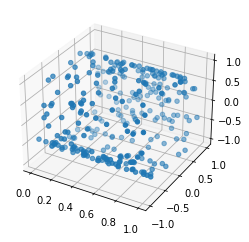

In [73]:
np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back
ss3=np.random.uniform(0,2*np.pi,300)
noise=np.random.normal(0,0.1,300) #add noise if you want


noise = 0 #to cancel noise
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)



rr3=np.random.uniform(0,1,300) #a point (xx,yy,rr3) on 3D
ax = plt.subplot(111, projection='3d')
ax.scatter(rr3,xx,yy) 
X=np.array(np.mat([rr3,xx,yy]).T,dtype=np.float32)
Z=X[:,:2]
plt.show()

In [19]:
  DX = tfa.losses.metric_learning.pairwise_distance(X)
  DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])

In [20]:
DXX

<tf.Tensor: shape=(1, 300, 300), dtype=float32, numpy=
array([[[0.       , 1.6566994, 1.9729589, ..., 1.7529038, 1.9613463,
         1.38675  ],
        [1.6566994, 0.       , 1.689401 , ..., 1.8121506, 1.4785941,
         2.0801737],
        [1.9729589, 1.689401 , 0.       , ..., 0.7533596, 0.5338575,
         1.0820504],
        ...,
        [1.7529038, 1.8121506, 0.7533596, ..., 0.       , 0.6006788,
         0.8014393],
        [1.9613463, 1.4785941, 0.5338575, ..., 0.6006788, 0.       ,
         1.2529532],
        [1.38675  , 2.0801737, 1.0820504, ..., 0.8014393, 1.2529532,
         0.       ]]], dtype=float32)>

In [21]:
tfa.losses.metric_learning.pairwise_distance(Z)

<tf.Tensor: shape=(300, 300), dtype=float32, numpy=
array([[0.        , 0.74302393, 1.9092441 , ..., 1.7528076 , 1.8654388 ,
        1.3244358 ],
       [0.74302393, 0.        , 1.3736913 , ..., 1.0702295 , 1.191959  ,
        0.8650766 ],
       [1.9092441 , 1.3736913 , 0.        , ..., 0.5814927 , 0.5227215 ,
        0.5879498 ],
       ...,
       [1.7528076 , 1.0702295 , 0.5814927 , ..., 0.        , 0.12538373,
        0.6766972 ],
       [1.8654388 , 1.191959  , 0.5227215 , ..., 0.12538373, 0.        ,
        0.7320587 ],
       [1.3244358 , 0.8650766 , 0.5879498 , ..., 0.6766972 , 0.7320587 ,
        0.        ]], dtype=float32)>

In [22]:
def loss(X,Z):
    modelR = RipsModel(P=Z, mel=12, dim=1, card = 150)

    #Compute persistence diagram
    Zdgm = modelR.call()[1]
    Xdgm = modelR.call()[0]

    print("i am about to calulcate loss")
    # Loss is Wasserstein distance
    loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))

    return loss


In [27]:
l = loss(X,Z)

i am about to calulcate loss


In [24]:
DXX = tf.reshape(DX, [1, 300, 300]) #manually put in tensor 

In [85]:
class CustomAccuracy1(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):

        # DX = tfa.losses.metric_learning.pairwise_distance(X)
        # DXX = tf.expand_dims(DX, axis = 0)
        # XRipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        # Xids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(XRipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        # print("Xids",Xids)

        #Q: how to extract data from tensor????? RipsModel converts the persistence diagrams to tensors.
        #Q: how to have all data go in at once into the neural network. not one sample at a time.  

        fig, ax = plt.subplots()
        
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        #ax.scatter(X[:,0].tolist(),X[:,1].tolist())
        plt.show()

        modelR = RipsModel(P=Y, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        #A = modelR.call()
        Zdgm = modelR.call()[1]
        sess=tf.compat.v1.InteractiveSession()
        print("type ofZdgm",type(Zdgm))
        D = Zdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
        Xdgm = modelR.call()[0]
        D1 = Xdgm.numpy()
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        plt.plot([0,0.5],[0,0.5])
        plt.show()


        # Loss is Wasserstein distance
        print("I am about to calculcate loss")
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))
        print("I calulcated loss",loss)

        return loss

In [47]:
import keras.backend as K

Epoch 1/2


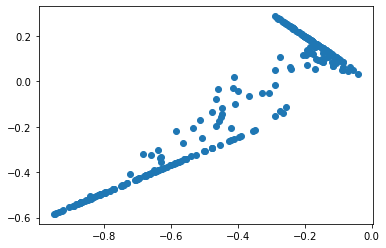

type ofZdgm <class 'tensorflow.python.framework.ops.EagerTensor'>


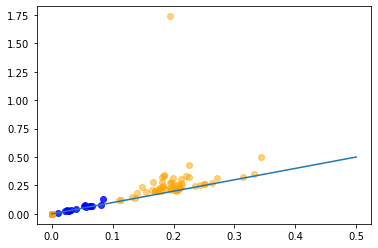

I am about to calculcate loss
I calulcated loss tf.Tensor(1.3275771, shape=(), dtype=float32)
1/1 [==============================] - 14s 14s/step - loss: 1.3276
Epoch 2/2


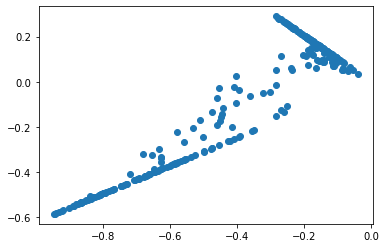

type ofZdgm <class 'tensorflow.python.framework.ops.EagerTensor'>


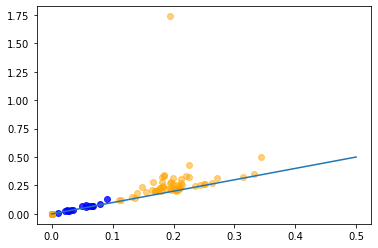

I am about to calculcate loss
I calulcated loss tf.Tensor(1.3272132, shape=(), dtype=float32)
1/1 [==============================] - 14s 14s/step - loss: 1.3272


In [86]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='relu'),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = "adam",run_eagerly=True)
model.fit(X, X,epochs=2,batch_size=300)

In [58]:
from platform import python_version

print(python_version())

3.8.5


In [ ]:
class CustomAccuracy(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Z):

        #Xids was throwing error, so not using RipsModel.
#         modelR = RipsModel(P=Z, mel=12, dim=1, card = 150)

        # Compute persistence diagram
#         Zdgm = modelR.call(X)[1]
#         Xdgm = modelR.call(X)[0]
        
        st = gd.RipsComplex(points = X, 
                            max_edge_length = 10).create_simplex_tree(max_dimension=2)
        st.persistence() 
        Xdgm = np.array(st.persistence_intervals_in_dimension(1), dtype=np.float32)

        st1 = gd.RipsComplex(points = Z, 
                            max_edge_length=10).create_simplex_tree(max_dimension=2)
        st1.persistence()
        Zdgm = np.array(st1.persistence_intervals_in_dimension(1), dtype=np.float32)



        # Loss is Wasserstein distance
        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))

        return loss.numpy()

In [ ]:
model.compile(optimizer='adam', loss = losses.MeanSquaredError(),
              metrics=['accuracy']) #change mean square error loss to custom

In [ ]:
model.predict(X)

array([[ 4.81847003e-02,  4.63319756e-02],
       [-1.41736662e+00, -1.05677330e+00],
       [-3.15383971e-01, -1.32714227e-01],
       [-4.08202037e-02,  2.49984488e-03],
       [-3.63034040e-01, -1.56180382e-01],
       [-3.00377607e-01, -1.25324041e-01],
       [-7.07339421e-02, -1.22317336e-02],
       [ 1.88334119e-02,  3.18773836e-02],
       [ 4.81847003e-02,  4.63319756e-02],
       [-6.61587536e-01, -5.31637788e-01],
       [ 4.81847003e-02,  4.63319756e-02],
       [-1.61818922e+00, -1.29020405e+00],
       [-6.78507239e-02, -1.08118355e-02],
       [-4.27146494e-01, -1.87753752e-01],
       [-4.63027060e-01, -2.05423802e-01],
       [-1.59243143e+00, -1.28090119e+00],
       [ 4.81847003e-02,  4.63319756e-02],
       [-1.05267262e+00, -8.48048627e-01],
       [-3.59740406e-01, -1.54558361e-01],
       [-1.17310174e-01, -3.51690687e-02],
       [-1.11816609e+00, -7.74209261e-01],
       [-4.77890909e-01, -2.12743789e-01],
       [-1.03128366e-02,  1.75237693e-02],
       [-1.